In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
SEQ_LEN = 50
N_SERIES = 20
OUT_LEN = 5
LR = 0.001
EPOCHS = 100

In [4]:
np.random.seed(42)

In [5]:
def gen_data(n_series: int, seq_len: int, noise: float):
    start_series_values = np.random.choice(range(0, 100), size=n_series)
    series = [np.linspace(start, start + seq_len, seq_len).round(3) for start in start_series_values]
    series = np.array(series)
    series = np.sin(series) + np.random.uniform(0, noise)
    return series

In [6]:
data = gen_data(n_series=20, seq_len=50, noise=0.2)

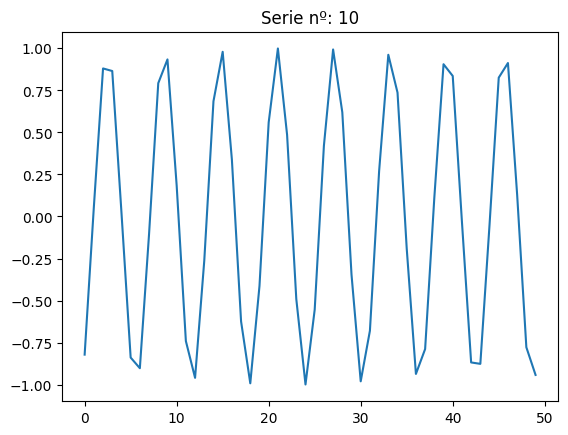

In [7]:
serie_numer_i = 10
plt.plot(data[serie_numer_i])
plt.title(f'Serie nº: {serie_numer_i}');

In [8]:
def split_data(data: np.array, output_len: int = OUT_LEN):
    return data[:, :-output_len], data[:, -output_len:]

In [64]:
data[0]

array([ 0.67038493,  0.98332643,  0.35810913, -0.60815052, -0.99442776,
       -0.43180687,  0.54259021,  0.9998788 ,  0.50332347, -0.47376639,
       -0.99821695, -0.57095066,  0.40164922,  0.99069702,  0.63472089,
       -0.32630267, -0.97633985, -0.69456988,  0.24945987,  0.95612989,
        0.75053196, -0.17136094, -0.92909106, -0.80099984,  0.09180328,
        0.89664288,  0.84635746, -0.01102767, -0.85775201, -0.88619767,
       -0.06919752,  0.81449569,  0.92090699,  0.14959551, -0.76481657,
       -0.94901609, -0.22742674,  0.71079452,  0.9713487 ,  0.30539243,
       -0.65153623, -0.98706887, -0.38075361,  0.58947858,  0.99700332,
        0.45426508, -0.52221408, -0.99984356, -0.52335385,  0.45218154])

In [66]:
inputs[0]

tensor([ 0.6704,  0.9833,  0.3581, -0.6082, -0.9944, -0.4318,  0.5426,  0.9999,
         0.5033, -0.4738, -0.9982, -0.5710,  0.4016,  0.9907,  0.6347, -0.3263,
        -0.9763, -0.6946,  0.2495,  0.9561,  0.7505, -0.1714, -0.9291, -0.8010,
         0.0918,  0.8966,  0.8464, -0.0110, -0.8578, -0.8862, -0.0692,  0.8145,
         0.9209,  0.1496, -0.7648, -0.9490, -0.2274,  0.7108,  0.9713,  0.3054,
        -0.6515, -0.9871, -0.3808,  0.5895,  0.9970], dtype=torch.float64)

In [67]:
targets[0]

tensor([ 0.4543, -0.5222, -0.9998, -0.5234,  0.4522], dtype=torch.float64)

In [9]:
inputs, targets = split_data(data)

In [10]:
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)

In [11]:
dataset = TensorDataset(inputs, targets)

In [12]:
dataloader = DataLoader(dataset, shuffle=False)

In [13]:
class SenoRNN(nn.Module):
    def __init__(self, H_in, H_out, N_layers):
        super(SenoRNN, self).__init__()
        self.H_in = H_in
        self.H_out = H_out
        self.N_layers = N_layers
        self.rnn = nn.RNN(input_size=self.H_in, hidden_size=self.H_out, num_layers=self.N_layers, batch_first=True)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[-1:, :]
        x = x.to(dtype=torch.double)
        return x

In [14]:
model = SenoRNN(H_in=1, H_out=5, N_layers=2)

In [15]:
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [16]:
loss_history = defaultdict(list)
optimizer.zero_grad(set_to_none=True)
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for X, y in dataloader:
        X = X.permute(1,0).to(torch.float32)
        y_hat = model(X)

        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    epoch_loss /= len(dataloader)
    loss_history['train_losses'].append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: [{epoch + 1}/{EPOCHS}] | Loss: {epoch_loss:.4f}')

Epoch: [10/100] | Loss: 0.4064
Epoch: [20/100] | Loss: 0.1506
Epoch: [30/100] | Loss: 0.0843
Epoch: [40/100] | Loss: 0.0551
Epoch: [50/100] | Loss: 0.0388
Epoch: [60/100] | Loss: 0.0287
Epoch: [70/100] | Loss: 0.0212
Epoch: [80/100] | Loss: 0.0149
Epoch: [90/100] | Loss: 0.0097
Epoch: [100/100] | Loss: 0.0062


In [17]:
print(f'{"  PREDICT  ":#^30}')
print(y_hat)
print(f'\n{"  LABEL  ":#^30}')
print(y)

#########  PREDICT  ##########
tensor([[ 0.8493,  0.7854, -0.2220, -0.8289, -0.6992]], dtype=torch.float64,
       grad_fn=<ToCopyBackward0>)

##########  LABEL  ###########
tensor([[ 0.9448,  0.7734, -0.1354, -0.9154, -0.8217]], dtype=torch.float64)


In [31]:
# Pegando uma time-series e plotando seu predict e seu valor verdadeiro
random_serie = np.random.randint(0, N_SERIES + 1)

In [33]:
inputs[random_serie]

tensor([-9.8499e-01, -3.6911e-01,  5.9958e-01,  9.9593e-01,  4.4215e-01,
        -5.3288e-01, -9.9978e-01, -5.1261e-01,  4.6335e-01,  9.9783e-01,
         5.8038e-01, -3.9018e-01, -9.8879e-01, -6.4375e-01,  3.1606e-01,
         9.7396e-01,  7.0286e-01, -2.3834e-01, -9.5218e-01, -7.5754e-01,
         1.5969e-01,  9.2523e-01,  8.0793e-01, -7.9388e-02, -8.9134e-01,
        -8.5246e-01,  1.9084e-04,  8.5228e-01,  8.9207e-01,  8.0626e-02,
        -8.0707e-01, -9.2489e-01, -1.6030e-01,  7.5725e-01,  9.5278e-01,
         2.3955e-01, -7.0260e-01, -9.7386e-01, -3.1568e-01,  6.4335e-01,
         9.8924e-01,  3.9135e-01, -5.7931e-01, -9.9751e-01, -4.6386e-01],
       dtype=torch.float64)

In [34]:
targets[random_serie]

tensor([ 0.5121,  1.0001,  0.5340, -0.4419, -0.9955], dtype=torch.float64)

In [71]:
predict.squeeze()

tensor([ 0.5338,  0.9241,  0.6152, -0.4680, -0.8541], dtype=torch.float64)

In [72]:
@torch.no_grad()
def predict_one_serie(model, data):
    model.eval()
    data = data.unsqueeze(1).to(torch.float32)
    predict = model(data).squeeze()
    return predict

In [73]:
predict = predict_one_serie(model, inputs[random_serie])

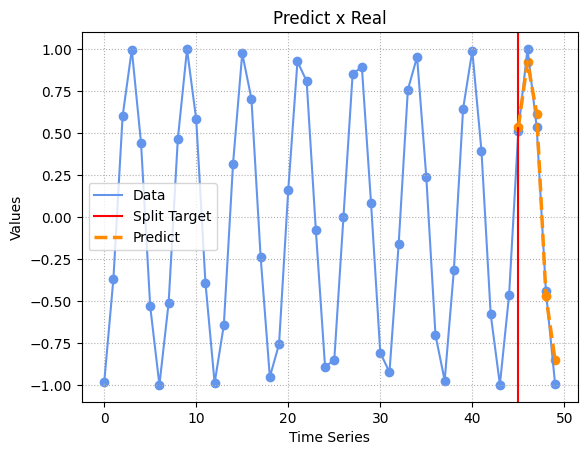

In [128]:
# plottando
fig, ax = plt.subplots()
ax.plot(range(50), data[random_serie], c='#6495ED', label='Data')
ax.scatter(range(50), data[random_serie], c='#6495ED', label=None)
ax.axvline(x=45, c='#FF0000', label='Split Target')
ax.plot(range(45,50), predict, linestyle='--', linewidth=2.5, c='#FF8C00', label='Predict')
ax.scatter(range(45,50), predict, c='#FF8C00')
ax.set_title('Predict x Real')
ax.set_ylabel('Values')
ax.set_xlabel('Time Series')
ax.grid(True, linestyle=':')
ax.legend()
plt.show()

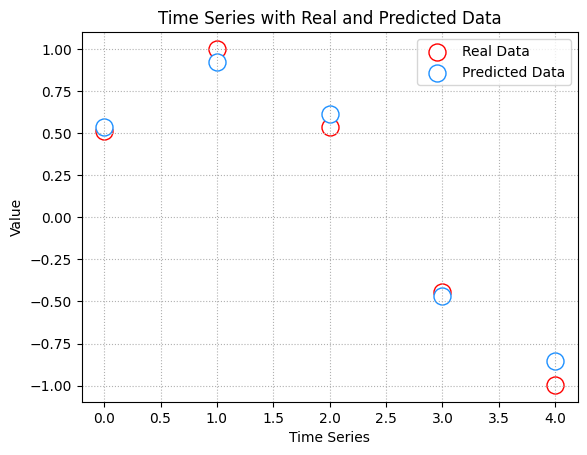

In [146]:
plt.figure()
plt.scatter(range(5), targets[random_serie], label='Real Data', c='white', s=150, edgecolors='#FF0000', )
plt.scatter(range(5), predict, label='Predicted Data', edgecolors='#1E90FF',c='white', s=150)
plt.xlabel('Time Series')
plt.ylabel('Value')
plt.title('Time Series with Real and Predicted Data')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()